# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje skupa dobijenog automatskom obradom, pre ručne provere i relabeliranja

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('/app/tennis_data/stroke_recognition_dataset/master/v1.0/action_images_dataset_v1.0/bottom')):
    X, y = load_data('/app/tennis_data/stroke_recognition_dataset/master/v1.0/action_images_dataset_v1.0/bottom', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 1895, Forehands count: 2293, Other count: 6142, Serve count: 1587
All strokes count: 11917


## Isprobavanje metode potpornih vektora

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

In [8]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = SVC(kernel='rbf', gamma='scale', shrinking=True, random_state=7)
clf.fit(X_train, y_train)

SVC(random_state=7)

In [9]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [10]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.9470862470862471
Precision: 0.9359406954062234
Recall: 0.9352992939219478
F1 Score: 0.9355853242268792

Validation set scores:
Accuracy: 0.9053613053613053
Precision: 0.8903336422125464
Recall: 0.8795330898204633
F1 Score: 0.8847366376270509


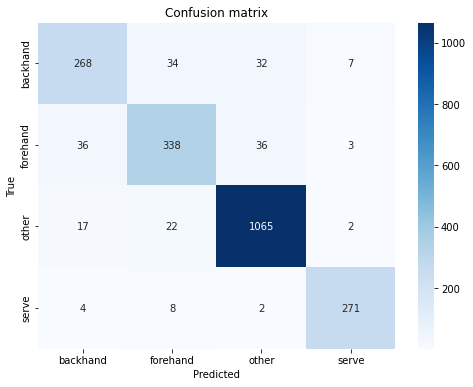

In [11]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.90      0.88      0.89      1364
    forehand       0.90      0.90      0.90      1651
       other       0.97      0.97      0.97      4422
       serve       0.97      0.98      0.97      1143

    accuracy                           0.95      8580
   macro avg       0.94      0.94      0.94      8580
weighted avg       0.95      0.95      0.95      8580



In [13]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.82      0.79      0.80       341
    forehand       0.84      0.82      0.83       413
       other       0.94      0.96      0.95      1106
       serve       0.96      0.95      0.95       285

    accuracy                           0.91      2145
   macro avg       0.89      0.88      0.88      2145
weighted avg       0.90      0.91      0.90      2145



## Pronalaženje najboljih hiperparametara

In [14]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [16]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'svc__C': [10**i for i in range(-2, 2)],
    'svc__kernel': ['sigmoid', 'rbf'],
    'svc__gamma': [10**i for i in range(-2, 2)],
}

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('svc', SVC(random_state=42))])

### Analiza hiperparametara

In [17]:
start = time.time()

grid_params_svc = GridSearchCV(grid_model, param_grid=params, scoring='f1_macro', verbose=True,
                               cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Time taken: 00:07:30.24


In [18]:
best_model = grid_params_svc.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc.best_score_}")
print(f"Best parameters: {grid_params_svc.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.8592442744308405
Best parameters: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Training set scores:
Accuracy: 0.999213217938631
Precision: 0.9990866085111338
Recall: 0.999044093576019
F1 Score: 0.999064653915757

Validation set scores:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Odmah moramo primetiti potencijalno nerealno visoke procente, ali sačekaćemo da proces dođe do kraja i vidimo kako stojimo na test setu.

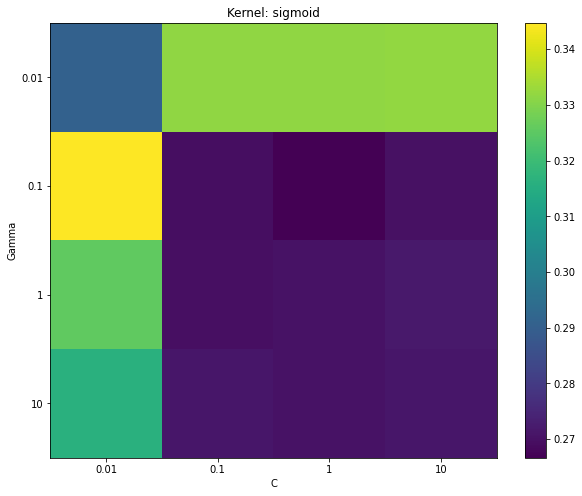

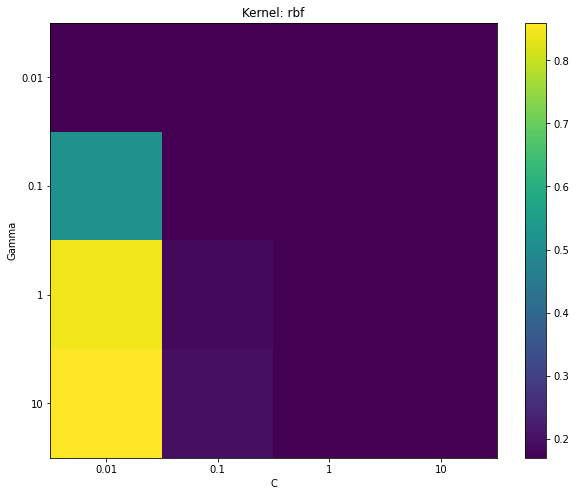

In [19]:
Cs = params['svc__C']
gammas = params['svc__gamma']
kernels = params['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

Sa plotova vidimo da su optimalne vrednosti hiperparametra `gamma` za različite kernele u različitom smeru. Jednom odgovaraju veće, jednom manje. Tako da ćemo u nastavku pokrenuti pretragu parametara za svaki kernel posebno. Ovo radimo da bismo ispoštovali proceduru od ranije, a i iz radoznalosti šta se nalazi u prostoru parametara.

### Za sigmoid kernel

In [20]:
start = time.time()

params_sig = {
    'svc__C': [10**i for i in range(0, 6)],
    'svc__kernel': ['sigmoid'],
    'svc__gamma': [10**i for i in range(-7, 1)],
}

grid_params_svc_sig = GridSearchCV(grid_model, param_grid=params_sig, scoring='f1_macro', verbose=True,
                                   cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc_sig.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Time taken: 00:05:44.59


In [21]:
best_model = grid_params_svc_sig.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc_sig.best_score_}")
print(f"Best parameters: {grid_params_svc_sig.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.8896458490144691
Best parameters: {'svc__C': 100000, 'svc__gamma': 1e-06, 'svc__kernel': 'sigmoid'}

Training set scores:
Accuracy: 0.9454497770784159
Precision: 0.9347204813209434
Recall: 0.9360729969977777
F1 Score: 0.9353944470708446

Validation set scores:
Accuracy: 0.9459884635553225
Precision: 0.9348799474769719
Recall: 0.9379878664677125
F1 Score: 0.9363920785199549


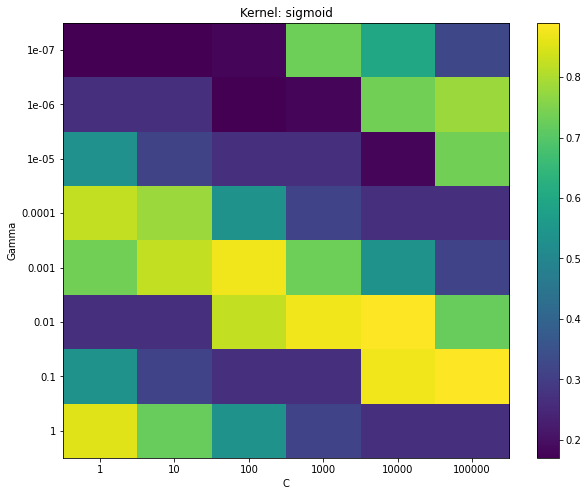

In [22]:
Cs = params_sig['svc__C']
gammas = params_sig['svc__gamma']
kernels = params_sig['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc_sig.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

### Za rbf kernel

In [23]:
start = time.time()

params_rbf = {
    'svc__C': [10**i for i in range(-1, 3)],
    'svc__kernel': ['rbf'],
    'svc__gamma': [10**i for i in range(-5, 1)],
}

grid_params_svc_rbf = GridSearchCV(grid_model, param_grid=params_rbf, scoring='f1_macro', verbose=True,
                                   cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc_rbf.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Time taken: 00:05:13.63


In [24]:
best_model = grid_params_svc_rbf.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc_rbf.best_score_}")
print(f"Best parameters: {grid_params_svc_rbf.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.9220978951143276
Best parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Training set scores:
Accuracy: 0.98426435877262
Precision: 0.9816602497220741
Recall: 0.980279853284153
F1 Score: 0.9809420458177338

Validation set scores:
Accuracy: 0.9889879391714735
Precision: 0.9866022792342355
Recall: 0.9879635327715708
F1 Score: 0.9872703192993


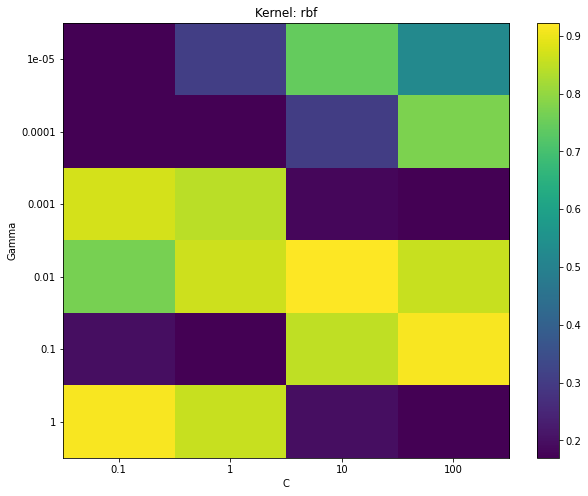

In [25]:
Cs = params_rbf['svc__C']
gammas = params_rbf['svc__gamma']
kernels = params_rbf['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc_rbf.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

Nakon analize oba kernela, biramo rbf i njegov najbolji model, između ostalog ima najbolji `mean_test_score` tako da ove rezultate proglašavamo konačnim kvalitetom modela. Napomena kao i u ostalim slučajevima, neće biti treniran model nad svim podacima iz skupa (uključujući i test), nego će biti eksportovana verzija trenirana nad trening i validacionim skupom da bi se prilikom demonstracije ili bilo kog daljeg koraka mogli koristiti primeri iz test skupa i dobijala relevantna predviđanja.

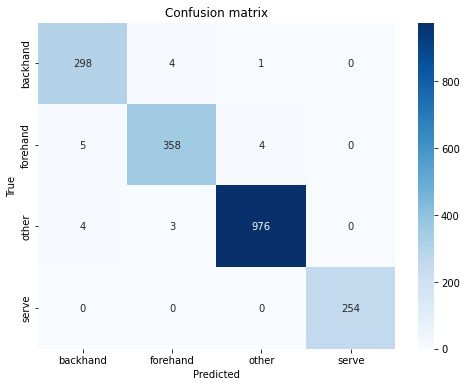

In [33]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.97      0.96      0.96      1213
    forehand       0.97      0.98      0.97      1467
       other       0.99      0.99      0.99      3930
       serve       1.00      1.00      1.00      1016

    accuracy                           0.98      7626
   macro avg       0.98      0.98      0.98      7626
weighted avg       0.98      0.98      0.98      7626



In [35]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.97      0.98      0.98       303
    forehand       0.98      0.98      0.98       367
       other       0.99      0.99      0.99       983
       serve       1.00      1.00      1.00       254

    accuracy                           0.99      1907
   macro avg       0.99      0.99      0.99      1907
weighted avg       0.99      0.99      0.99      1907



Ovaj model daje zaista sjajne rezultate i možemo se samo nadati da su naši transformisani podaci (sličice) koji predstavljaju udarce (video klipove od jedne sekunde) poprilično razdvojivi nekom nelinearnom granicom. U nastavku ćemo videti ponašanje na test skupu da ovu ideju bar malo testiramo.

## Procena modela na test skupu

In [36]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.9521812080536913
Precision: 0.9417581832134871
Recall: 0.9384585434559973
F1 Score: 0.9400702502143433


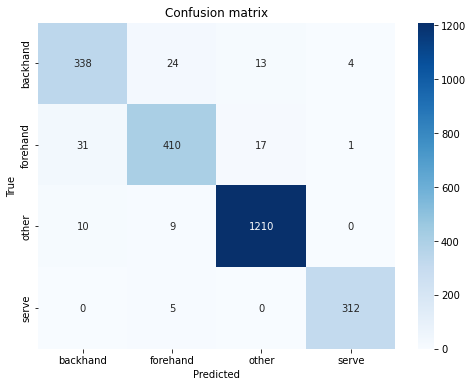

In [37]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [38]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.89      0.89      0.89       379
    forehand       0.92      0.89      0.90       459
       other       0.98      0.98      0.98      1229
       serve       0.98      0.98      0.98       317

    accuracy                           0.95      2384
   macro avg       0.94      0.94      0.94      2384
weighted avg       0.95      0.95      0.95      2384



Ipak kao i u svim implementiranim slučajevima dobijamo nešto lošije rezultate za test skup, ipak ovi rezultati za SVM su zaista fenomenalni. Posebno ako na primer pogledamo izdvojene klase `other` i `serve`, za koje radi skoro savršeno.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [39]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/03_svm_relabeled_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)